In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model,Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, EfficientNetV2M 
from tensorflow.keras.applications import VGG19

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dogdir = '/content/drive/MyDrive/Dog_Breed'
ldis_typ = os.listdir(dogdir)
trdr = os.path.join(dogdir)
dirs=os.listdir(dogdir)
tot=0
for i in dirs:
    ldr=os.path.join(dogdir ,i)
    print("Total Available Images in {} ==> {}.".format(i,len(os.listdir(ldr))))
    tot+=len(os.listdir(ldr))
print("\nCount of Images: ",tot)

Total Available Images in Bedlington_terrier ==> 182.
Total Available Images in Giant_schnauzer ==> 157.
Total Available Images in Scottish_deerhound ==> 232.
Total Available Images in Blenheim_spaniel ==> 188.
Total Available Images in Japanese_spaniel ==> 185.
Total Available Images in Shih-Tzu ==> 214.
Total Available Images in Chihuahua ==> 152.
Total Available Images in Clumber ==> 150.
Total Available Images in Walker_hound ==> 153.
Total Available Images in Golden_retriever ==> 150.

Count of Images:  1763


In [ ]:
data_to_train = []
for defects_id, sp in enumerate(ldis_typ):
    for file in os.listdir(os.path.join(trdr, sp)):
        data_to_train.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(data_to_train, columns=['File', 'DogID','DogType'])
train = train.sample(frac=1, random_state=42) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DogID,DogType
0,Clumber/n02101556_5940.jpg,7,Clumber
1,Giant_schnauzer/n02097130_5709.jpg,1,Giant_schnauzer
2,Scottish_deerhound/n02092002_1147.jpg,2,Scottish_deerhound
3,Blenheim_spaniel/n02086646_356.jpg,3,Blenheim_spaniel
4,Walker_hound/n02089867_1988.jpg,8,Walker_hound


In [ ]:
trntyp=train['DogType'].value_counts().index.tolist()
print(trntyp)
cnt=train['DogType'].value_counts().tolist()
dssdf=pd.DataFrame({"Type":trntyp,"Count":cnt})
fig = px.bar(dssdf, y="Type", x="Count",
             text="Count",color="Type",
             title="Count of Labels in Databse",height=500,width=800)
fig.update_layout(
        font=dict(
            family="Times New Roman, Bold",
            size=20,
            color="dodgerblue"
        )
    )
fig.show()


['Scottish_deerhound', 'Shih-Tzu', 'Blenheim_spaniel', 'Japanese_spaniel', 'Bedlington_terrier', 'Giant_schnauzer', 'Walker_hound', 'Chihuahua', 'Golden_retriever', 'Clumber']


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
			Showing Images belongs to Scottish_deerhound
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


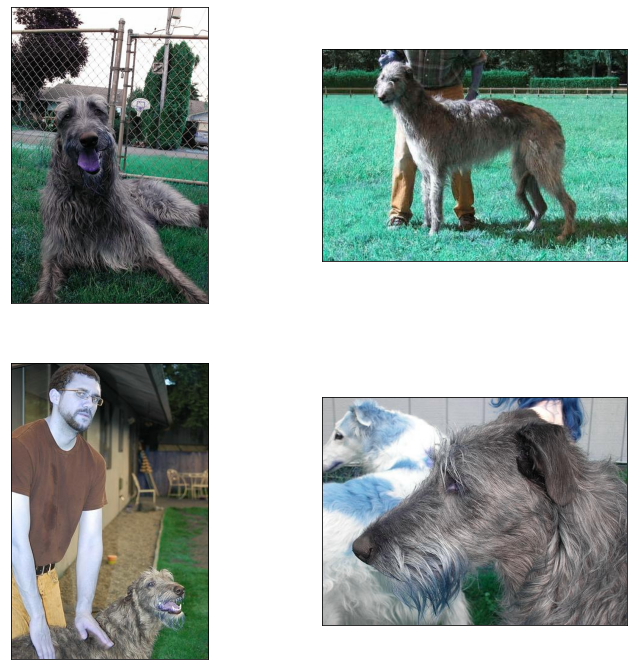

In [ ]:
def func_disease(typ_ds, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['DogType'] == typ_ds].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(dogdir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("\t\t\tShowing Images belongs to Scottish_deerhound")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
func_disease('Scottish_deerhound', 2,2)


In [ ]:
IMAGE_SIZE = 64

def read_image(path):
    return cv2.imread(os.path.join(dogdir, path))
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

32it [00:23,  1.36it/s]


KeyboardInterrupt: ignored

In [ ]:
Y_train = train['DogID'].values
Y_train = to_categorical(Y_train, num_classes=10)

In [ ]:
BATCH_SIZE = 64
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=42)
datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True, 
                        vertical_flip=True)

datagen.fit(X_train)


80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
deepmods=[DenseNet201(weights='imagenet', include_top=False),
          ResNet152V2(weights='imagenet', include_top=False),
          EfficientNetV2B0(weights='imagenet', include_top=False),
          VGG19(weights='imagenet', include_top=False)
          ]
dmnames=["Densenet","ResNet","EfficientNet","VGG"]

80150528/80134624 [==============================] - 0s 0us/step


## Executing with image Size 64x64

                               Executing Densenet Model(64x64,360 Rotation)
Model: "Densenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 densenet201 (Functional)    (None, None, None, 1920)  18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                

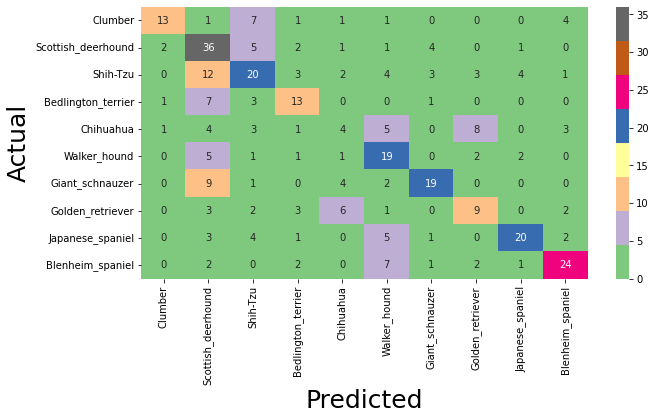

-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--
                    Performance Graph for Densenet Model(64x64,360 Rotation)
-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--


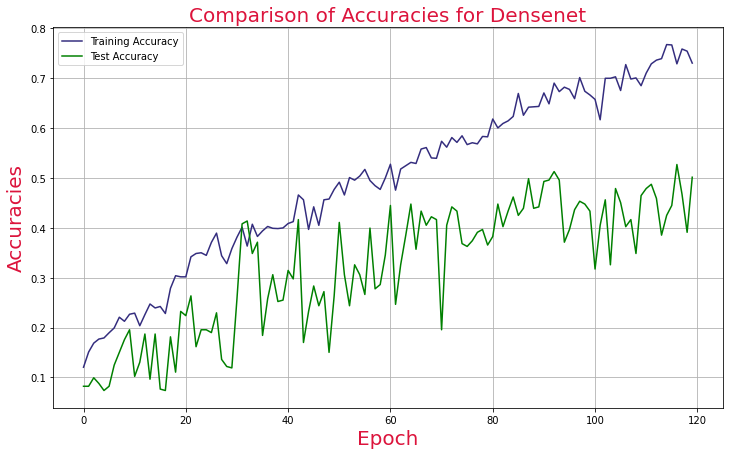

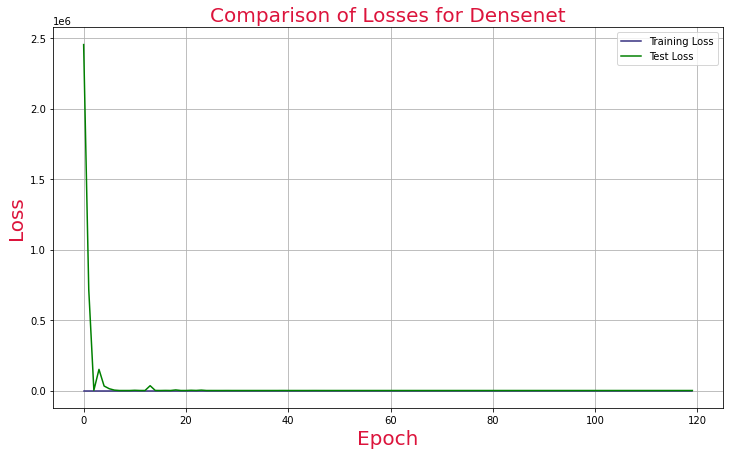

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Continue to Next Model? (Y/N)Y
                               Executing ResNet Model(64x64,360 Rotation)
Model: "ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 resnet152v2 (Functional)    (None, None, None, 2048)  58331648  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8

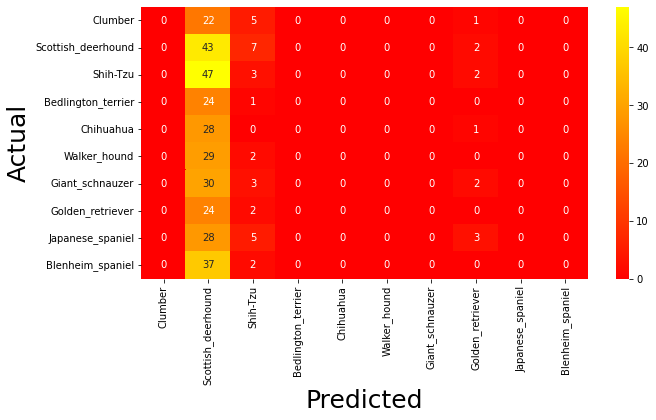

-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--
                    Performance Graph for ResNet Model(64x64,360 Rotation)
-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--


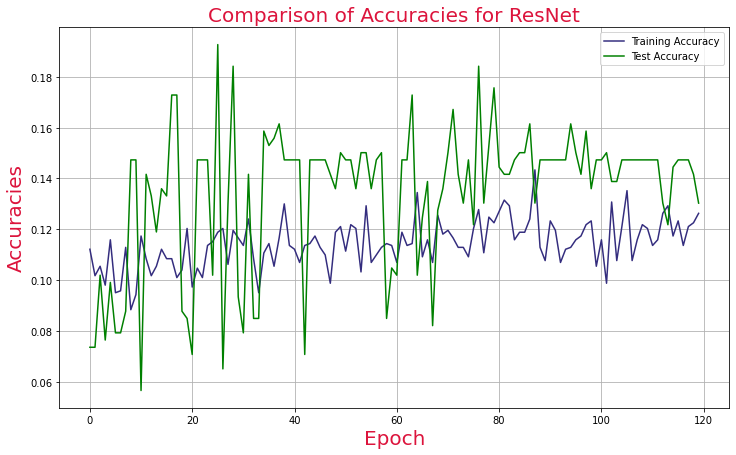

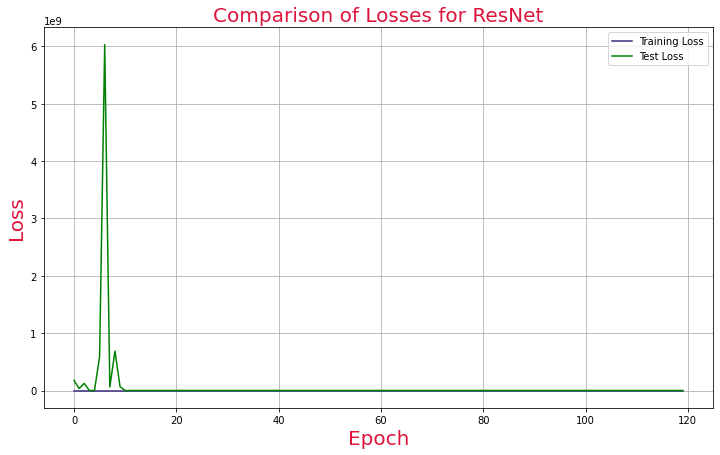

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Continue to Next Model? (Y/N)Y
                               Executing EfficientNet Model(64x64,360 Rotation)
Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                            

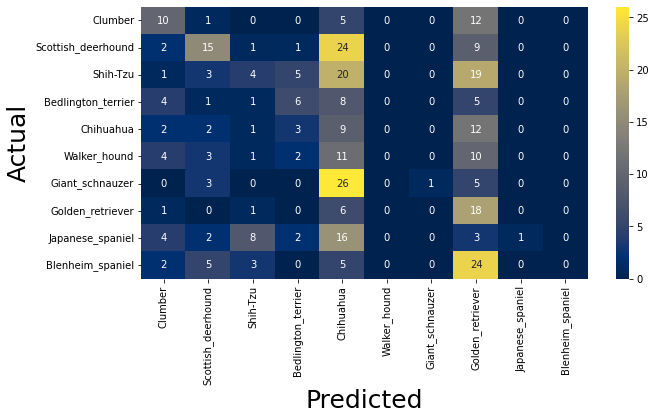

-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--
                    Performance Graph for EfficientNet Model(64x64,360 Rotation)
-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--


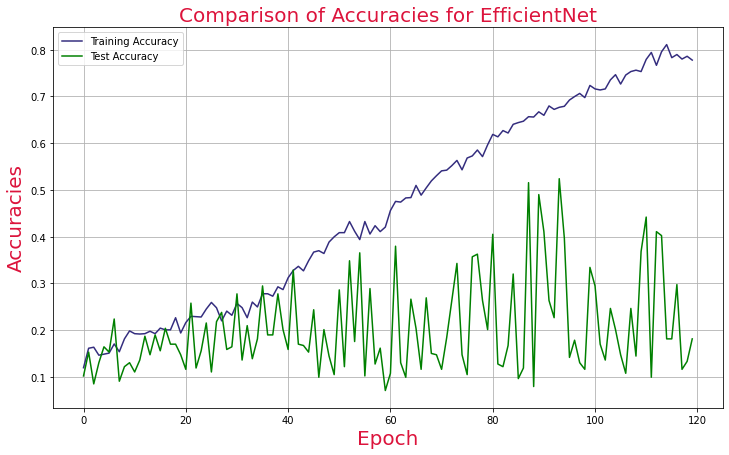

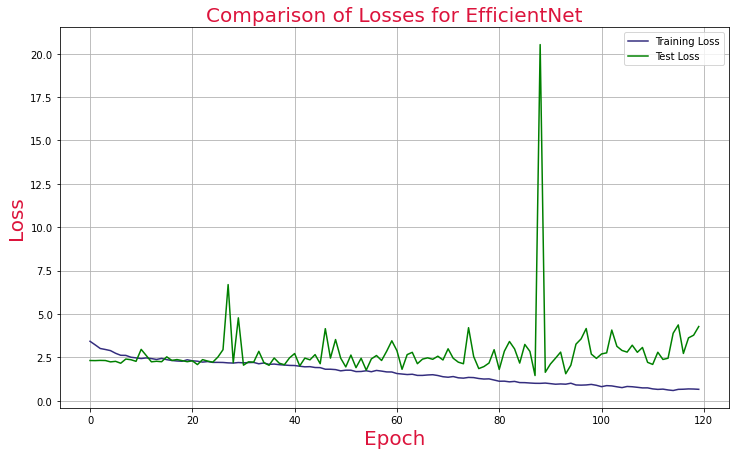

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Continue to Next Model? (Y/N)Y
                               Executing VGG Model(64x64,360 Rotation)
Model: "VGG"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048   

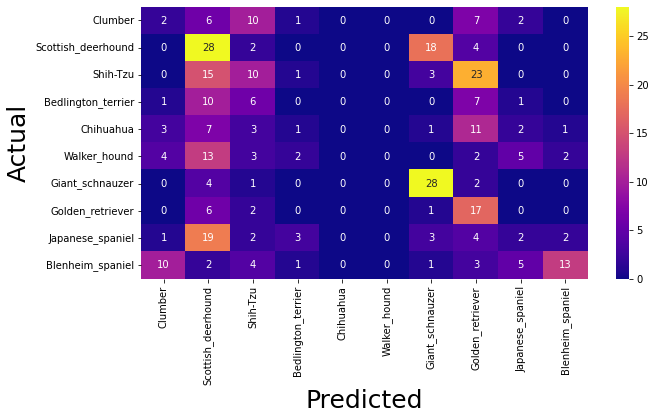

-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--
                    Performance Graph for VGG Model(64x64,360 Rotation)
-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--


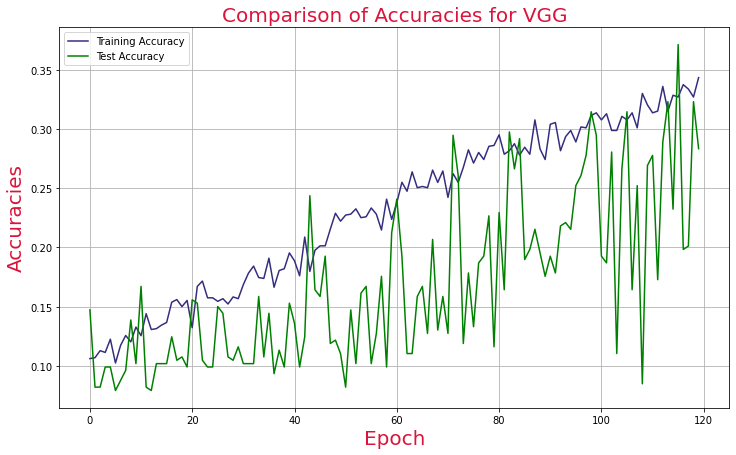

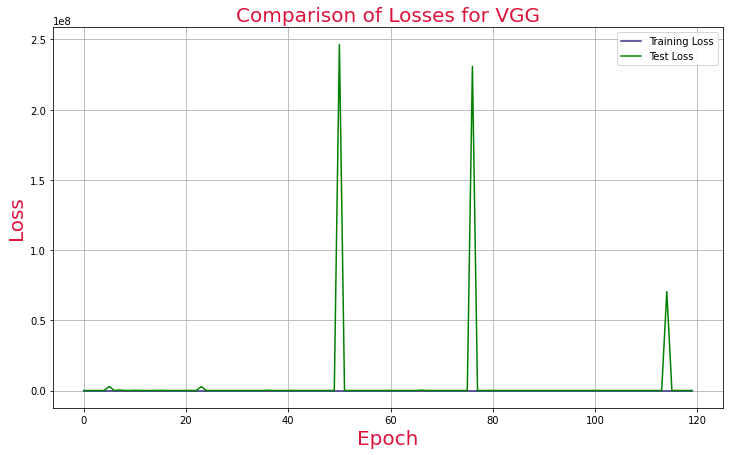

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Continue to Next Model? (Y/N)Y


In [ ]:
accdm,prcdm,rcldm,f1dm,accdmtr,lossdmtr=[],[],[],[],[],[]
epch=120
confclrs=["Accent","autumn","cividis","plasma"]
exemodels=[]

def Func_DeepModels(modl):
    deep_model = modl

    input = Input(shape=(64,64, 3))
    lyrdm = Conv2D(3, (3, 3), padding='same')(input)
    lyrdm = deep_model(lyrdm)
    lyrdm = GlobalAveragePooling2D()(lyrdm)
    lyrdm = BatchNormalization()(lyrdm)
    lyrdm = Dropout(0.5)(lyrdm)
    lyrdm = Dense(256, activation='relu')(lyrdm)
    lyrdm = BatchNormalization()(lyrdm)
    lyrdm = Dropout(0.5)(lyrdm)
    output = Dense(10,activation = 'softmax', name='root')(lyrdm)
    dpm_model = Model(input,output, name="{}".format(dmnames[i]))
    dpm_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    dpm_model.summary()
    return dpm_model

for i in range(len(deepmods)):
    print("=================================================================================================")
    print("                               Executing {} Model(64x64,360 Rotation)".format(dmnames[i]))
    print("=================================================================================================")
    dpm_model = Func_DeepModels(deepmods[i])
    dpm_dct = dpm_model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                   steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                   epochs=epch,
                   verbose=2,
                   validation_data=(X_val, Y_val))
    exemodels.append(dpm_model)
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    print("                    Test Performance for {} Model(64x64,360 Rotation)".format(dmnames[i]))
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    final_lossdpm, final_acrdpm = dpm_model.evaluate(X_val, Y_val)
    print('Final Loss: {}, Final Accuracy: {}%'.format(final_lossdpm, round(final_acrdpm,3)*100))
    accdmtr.append(round(final_acrdpm,3)*100)
    lossdmtr.append(round(final_lossdpm,3))
    
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    print("                    Confusion Matrix for {} Model(64x64,360 Rotation)".format(dmnames[i]))
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    Y_pred = dpm_model.predict(X_val)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.argmax(Y_val, axis=1)

    cm = confusion_matrix(Y_true, Y_pred)
    plt.figure(figsize=(10,5))
    ax = sns.heatmap(cm, fmt="d",annot=True,cmap=confclrs[i], xticklabels=ldis_typ, yticklabels=ldis_typ)
    ax.set_ylabel('Actual', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()
    accdm.append(round(accuracy_score(Y_true,Y_pred),3)*100)
    prcdm.append(round(precision_score(Y_true,Y_pred,average="weighted"),3)*100)
    rcldm.append(round(recall_score(Y_true,Y_pred,average="weighted"),3)*100)
    f1dm.append(round(f1_score(Y_true,Y_pred,average="weighted"),3)*100)
    dpm19df=pd.DataFrame({
        "Epoch":[i+1 for i in range(epch)],
        "Training Loss":dpm_dct.history['loss'],
        "Test Loss":dpm_dct.history['val_loss'],
        "Training Accuracy":dpm_dct.history['accuracy'],
        "Test Accuracy":dpm_dct.history['val_accuracy']
    })
    dpm19df.to_csv("dog_{}.csv".format(dmnames[i]))
    tlcol="#DC143C"
    v1,v2=1,3
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    print("                    Performance Graph for {} Model(64x64,360 Rotation)".format(dmnames[i]))
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    dpm19df.iloc[:,v2:].plot(kind="line",figsize=(12,7),color=["#342D7E","#008000"])
    plt.title("Comparison of Accuracies for {}".format(dmnames[i]),fontsize=20,color=tlcol)
    plt.xlabel("Epoch",fontsize=20,color=tlcol)
    plt.ylabel("Accuracies",fontsize=20,color=tlcol)
    plt.grid()
    plt.show()

    dpm19df.iloc[:,v1:v2].plot(kind="line",figsize=(12,7),color=["#342D7E","#008000"])
    plt.title("Comparison of Losses for {}".format(dmnames[i]),fontsize=20,color=tlcol)
    plt.xlabel("Epoch",fontsize=20,color=tlcol)
    plt.ylabel("Loss",fontsize=20,color=tlcol)
    plt.grid()
    plt.show()
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    ch=input("Continue to Next Model? (Y/N)")
    if ch=="Y" or ch=="y":
      continue
    else:
      break


In [ ]:
accdf=pd.DataFrame({"Model":dmnames,"Accuracy":accdm,"Precision":prcdm,"Recall":rcldm,"F1":f1dm,"Training Accuracy":accdmtr,"Training Loss":lossdmtr})
accdf=accdf.sort_values(by="Accuracy",ascending=False)
accdf
for i in accdf.columns.tolist()[1:]:
    accout=accdf.sort_values(by=i,ascending=False)
    fig = px.bar(accout, y=i, x="Model",color="Model",text=i,title="Comparison of {}".format(i),width=700)
    fig.update_layout(
        font=dict(
            family="Times New Roman, Bold",
            size=20,
            color="black"
        )
    )
    fig.show()

## Executing with image Size 96x96

In [ ]:
IMAGE_SIZE = 128

def read_image(path):
    return cv2.imread(os.path.join(dogdir, path))
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

Y_train = train['DogID'].values
Y_train = to_categorical(Y_train, num_classes=10)
BATCH_SIZE = 64
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=42)
datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True, 
                        vertical_flip=True)

datagen.fit(X_train)

1763it [00:11, 149.19it/s]


Train Shape: (1763, 128, 128, 3)


                               Executing Densenet Model(120x120,360 Rotation)
Model: "Densenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 3)       84        
                                                                 
 densenet201 (Functional)    (None, None, None, 1920)  18321984  
                                                                 
 global_average_pooling2d_2   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_4 (Batc  (None, 1920)             7680      
 hNormalization)                                                 
                                              

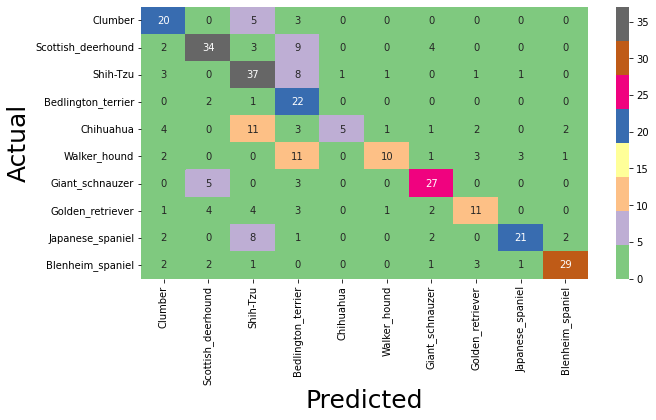

-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--
                    Performance Graph for Densenet Model(96x96,360 Rotation)
-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--


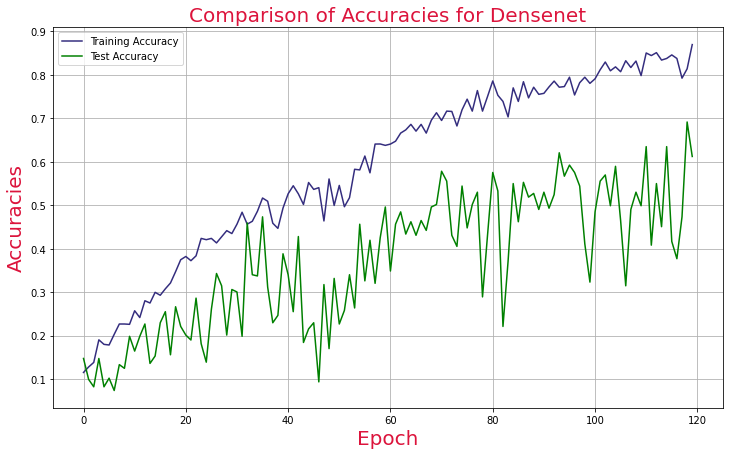

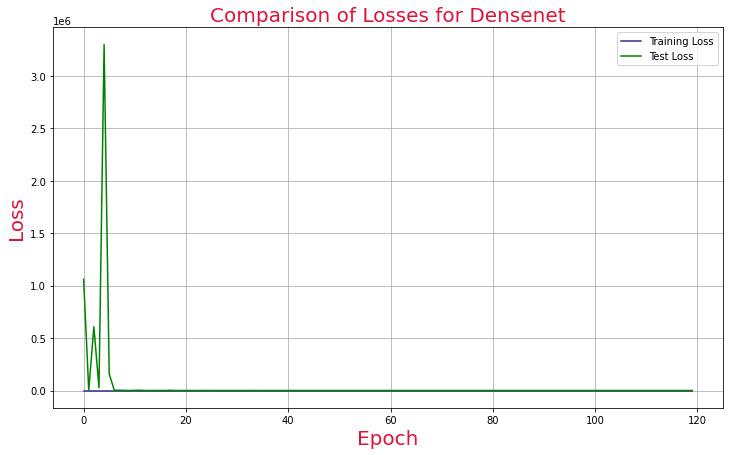

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                               Executing ResNet Model(120x120,360 Rotation)
Model: "ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 3)       84        
                                                                 
 resnet152v2 (Functional)    (None, None, None, 2048)  58331648  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_6 (Batc  (None, 2048)             8192      
 hNormalization)   

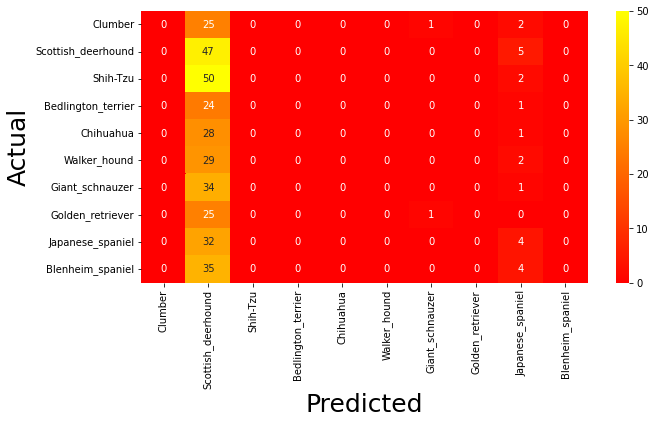

-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--
                    Performance Graph for ResNet Model(96x96,360 Rotation)
-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--


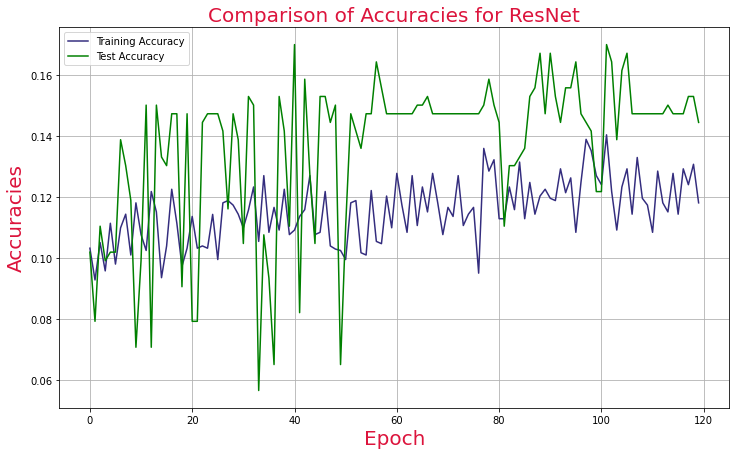

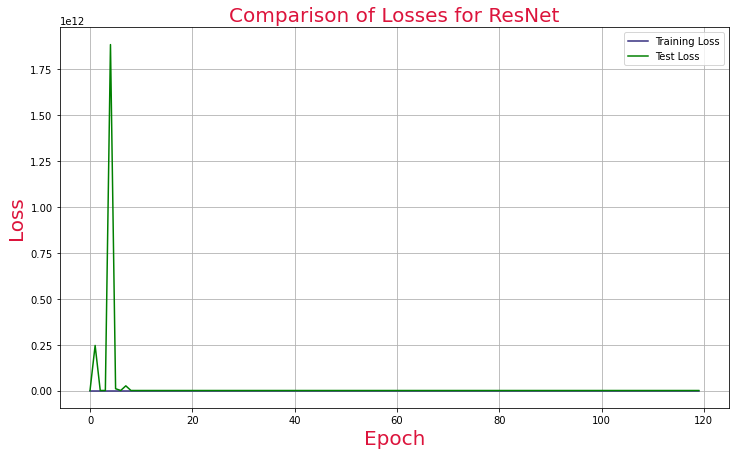

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                               Executing EfficientNet Model(120x120,360 Rotation)
Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 3)       84        
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_

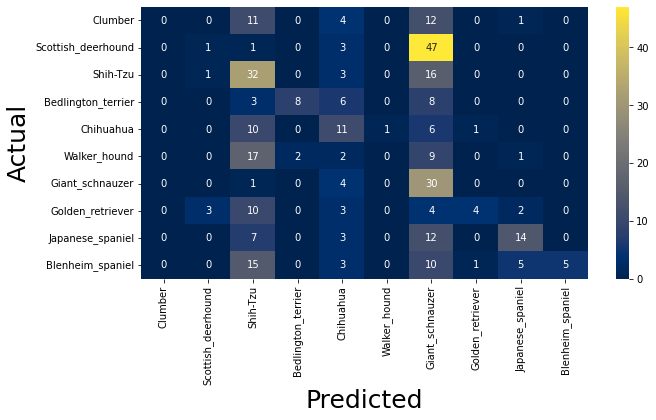

-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--
                    Performance Graph for EfficientNet Model(96x96,360 Rotation)
-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--


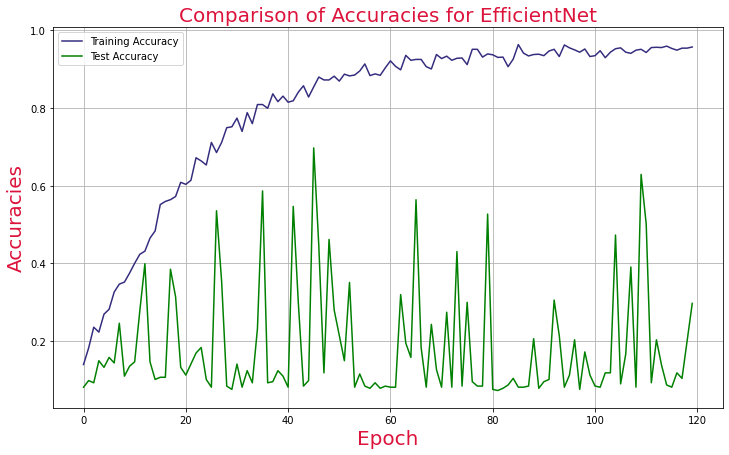

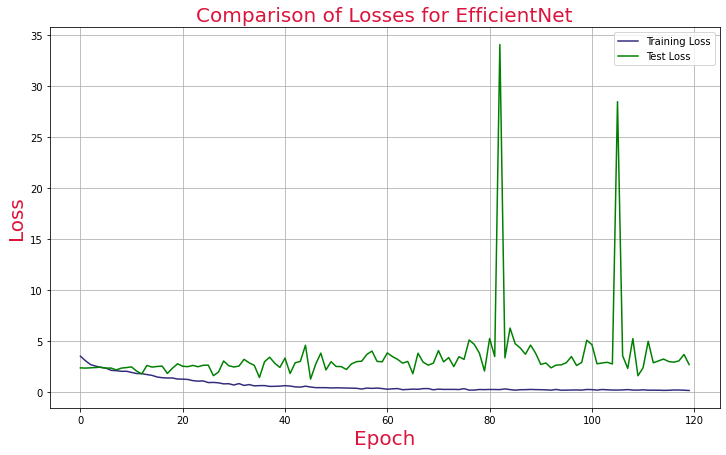

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
                               Executing VGG Model(120x120,360 Rotation)
Model: "VGG"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 3)       84        
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_10 (Bat  (None, 512)              2048      
 chNormalization)        

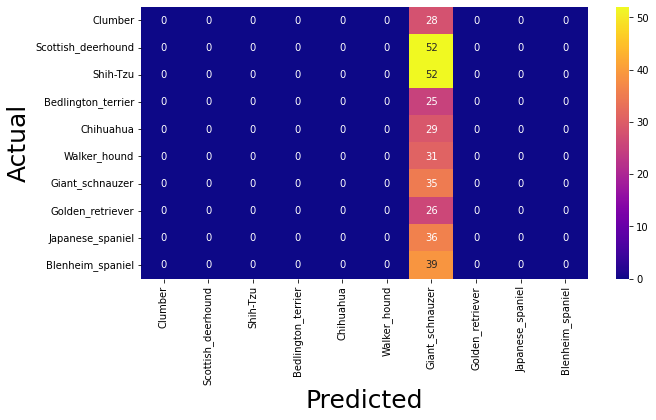

-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--
                    Performance Graph for VGG Model(96x96,360 Rotation)
-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--


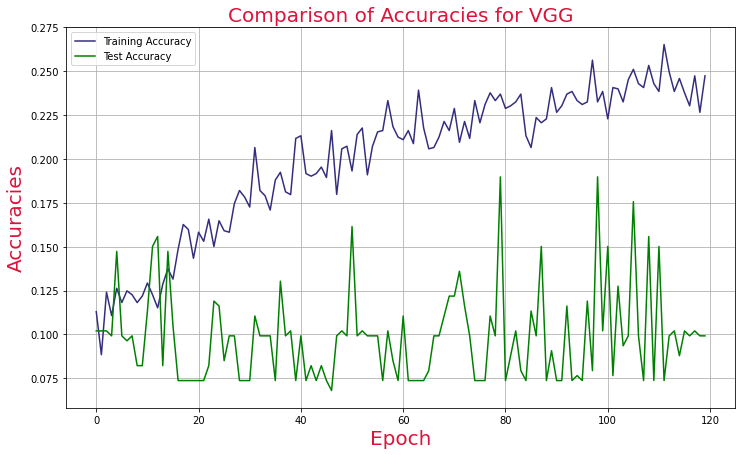

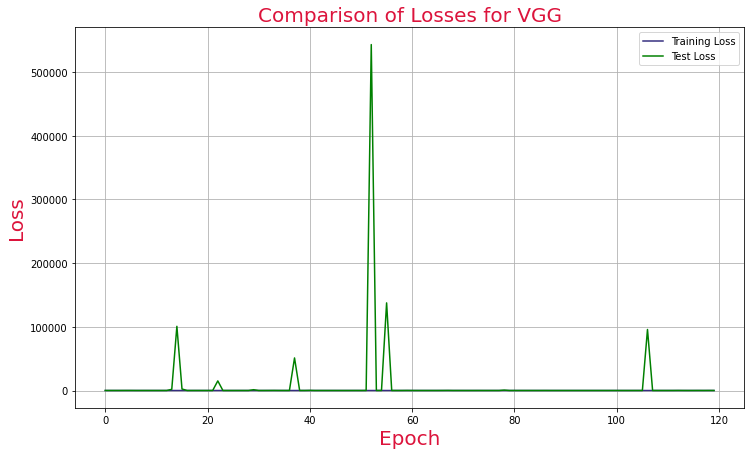

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Continue to Next Model? (Y/N)Y


In [ ]:
accdm1,prcdm1,rcldm1,f1dm1,accdm1tr,lossdm1tr=[],[],[],[],[],[]
epch=120
confclrs=["Accent","autumn","cividis","plasma"]
exemodels1=[]

def Func_DeepModels(modl):
    deep_model = modl

    input = Input(shape=(128,128, 3))
    lyrdm = Conv2D(3, (3, 3), padding='same')(input)
    lyrdm = deep_model(lyrdm)
    lyrdm = GlobalAveragePooling2D()(lyrdm)
    lyrdm = BatchNormalization()(lyrdm)
    lyrdm = Dropout(0.5)(lyrdm)
    lyrdm = Dense(256, activation='relu')(lyrdm)
    lyrdm = BatchNormalization()(lyrdm)
    lyrdm = Dropout(0.5)(lyrdm)
    output = Dense(10,activation = 'softmax', name='root')(lyrdm)
    dpm_model = Model(input,output, name="{}".format(dmnames[i]))
    dpm_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    dpm_model.summary()
    return dpm_model

for i in range(len(deepmods)):
    print("=================================================================================================")
    print("                               Executing {} Model(120x120,360 Rotation)".format(dmnames[i]))
    print("=================================================================================================")
    dpm_model = Func_DeepModels(deepmods[i])
    dpm_dct = dpm_model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                   steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                   epochs=epch,
                   verbose=2,
                   validation_data=(X_val, Y_val))
    exemodels1.append(dpm_model)
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    print("                    Test Performance for {} Model(96x96,360 Rotation)".format(dmnames[i]))
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    final_lossdpm, final_acrdpm = dpm_model.evaluate(X_val, Y_val)
    print('Final Loss: {}, Final Accuracy: {}%'.format(final_lossdpm, round(final_acrdpm,3)*100))
    accdm1tr.append(round(final_acrdpm,3)*100)
    lossdm1tr.append(round(final_lossdpm,3))
    
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    print("                    Confusion Matrix for {} Model(96x96,360 Rotation)".format(dmnames[i]))
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    Y_pred = dpm_model.predict(X_val)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.argmax(Y_val, axis=1)

    cm = confusion_matrix(Y_true, Y_pred)
    plt.figure(figsize=(10,5))
    ax = sns.heatmap(cm, fmt="d",annot=True,cmap=confclrs[i], xticklabels=ldis_typ, yticklabels=ldis_typ)
    ax.set_ylabel('Actual', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()
    accdm1.append(round(accuracy_score(Y_true,Y_pred),3)*100)
    prcdm1.append(round(precision_score(Y_true,Y_pred,average="weighted"),3)*100)
    rcldm1.append(round(recall_score(Y_true,Y_pred,average="weighted"),3)*100)
    f1dm1.append(round(f1_score(Y_true,Y_pred,average="weighted"),3)*100)
    dpm19df=pd.DataFrame({
        "Epoch":[i+1 for i in range(epch)],
        "Training Loss":dpm_dct.history['loss'],
        "Test Loss":dpm_dct.history['val_loss'],
        "Training Accuracy":dpm_dct.history['accuracy'],
        "Test Accuracy":dpm_dct.history['val_accuracy']
    })
    dpm19df.to_csv("coin_{}.csv".format(dmnames[i]))
    tlcol="#DC143C"
    v1,v2=1,3
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    print("                    Performance Graph for {} Model(96x96,360 Rotation)".format(dmnames[i]))
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    dpm19df.iloc[:,v2:].plot(kind="line",figsize=(12,7),color=["#342D7E","#008000"])
    plt.title("Comparison of Accuracies for {}".format(dmnames[i]),fontsize=20,color=tlcol)
    plt.xlabel("Epoch",fontsize=20,color=tlcol)
    plt.ylabel("Accuracies",fontsize=20,color=tlcol)
    plt.grid()
    plt.show()

    dpm19df.iloc[:,v1:v2].plot(kind="line",figsize=(12,7),color=["#342D7E","#008000"])
    plt.title("Comparison of Losses for {}".format(dmnames[i]),fontsize=20,color=tlcol)
    plt.xlabel("Epoch",fontsize=20,color=tlcol)
    plt.ylabel("Loss",fontsize=20,color=tlcol)
    plt.grid()
    plt.show()
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    ch=input("Continue to Next Model? (Y/N)")
    if ch=="Y" or ch=="y":
      continue
    else:
      break


In [ ]:
accdf1=pd.DataFrame({"Model":dmnames,"Accuracy":accdm1,"Precision":prcdm1,"Recall":rcldm1,"F1":f1dm1,"Training Accuracy":accdm1tr,"Training Loss":lossdm1tr})
accdf1=accdf1.sort_values(by="Accuracy",ascending=False)
for i in accdf1.columns.tolist()[1:]:
    accout1=accdf1.sort_values(by=i,ascending=False)
    fig = px.bar(accout1, y=i, x="Model",color="Model",text=i,title="Comparison of {}".format(i),width=700)
    fig.update_layout(
        font=dict(
            family="Times New Roman, Bold",
            size=20,
            color="black"
        )
    )
    fig.show()

## Executing with image Size 96x96 with rotation 180 degree

In [ ]:
IMAGE_SIZE = 196

deepmods=[DenseNet201(weights='imagenet', include_top=False),
          ResNet152V2(weights='imagenet', include_top=False),
          EfficientNetV2B0(weights='imagenet', include_top=False),
          VGG19(weights='imagenet', include_top=False)
          ]
dmnames=["Densenet","ResNet","EfficientNet","VGG"]

def read_image(path):
    return cv2.imread(os.path.join(dogdir, path))
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

Y_train = train['DogID'].values
Y_train = to_categorical(Y_train, num_classes=10)
BATCH_SIZE = 64
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=42)
datagen = ImageDataGenerator(rotation_range=180, 
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True, 
                        vertical_flip=True)

datagen.fit(X_train)

80150528/80134624 [==============================] - 0s 0us/step


1763it [12:25,  2.37it/s]


Train Shape: (1763, 196, 196, 3)


                               Executing Densenet Model(196x196,180 Rotation)
Model: "Densenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 196, 196, 3)       84        
                                                                 
 densenet201 (Functional)    (None, None, None, 1920)  18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                              

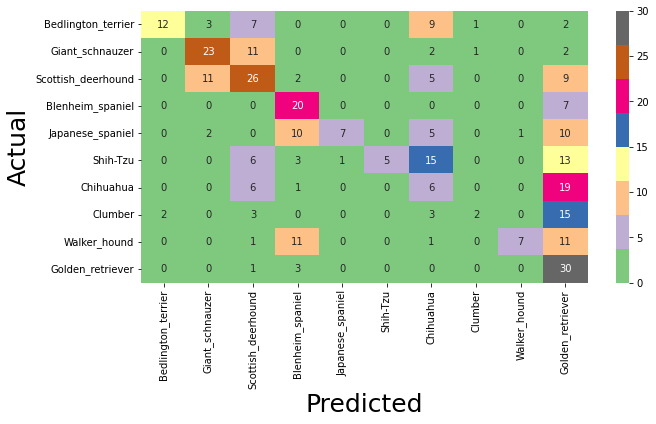

-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--
                    Performance Graph for Densenet Model(96x96,180 Rotation)
-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--


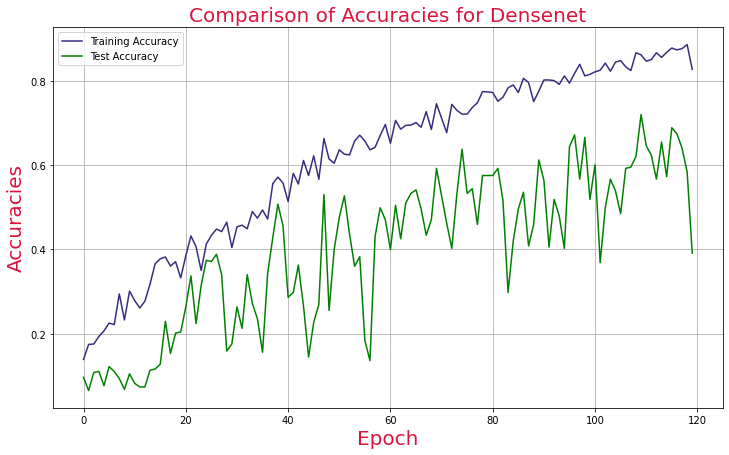

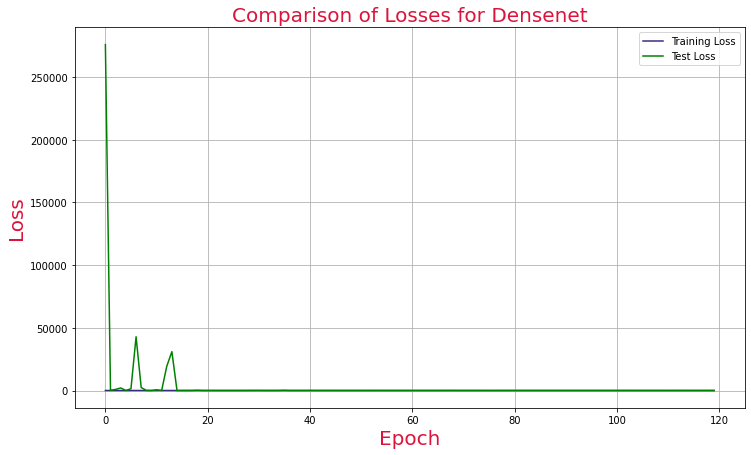

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Continue to Next Model? (Y/N)Y
                               Executing ResNet Model(196x196,180 Rotation)
Model: "ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 3)       84        
                                                                 
 resnet152v2 (Functional)    (None, None, None, 2048)  58331648  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 2048)            

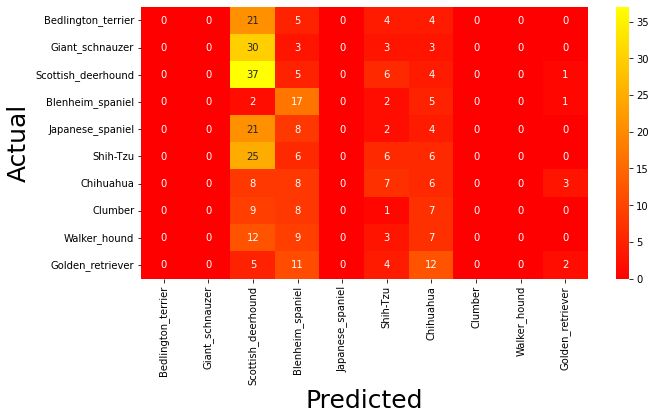

-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--
                    Performance Graph for ResNet Model(96x96,180 Rotation)
-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--


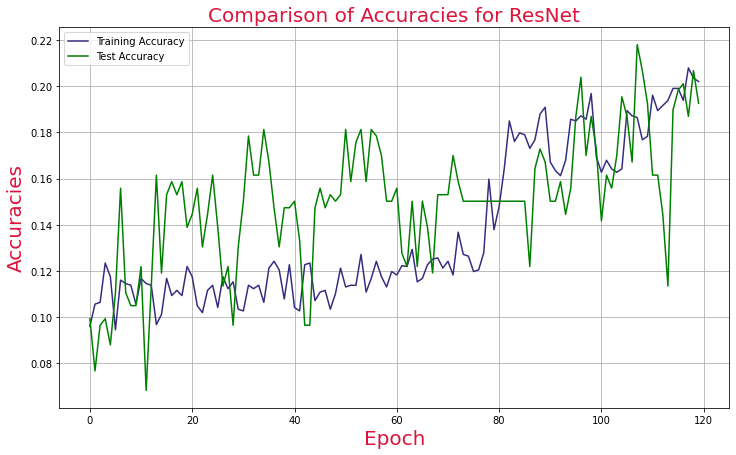

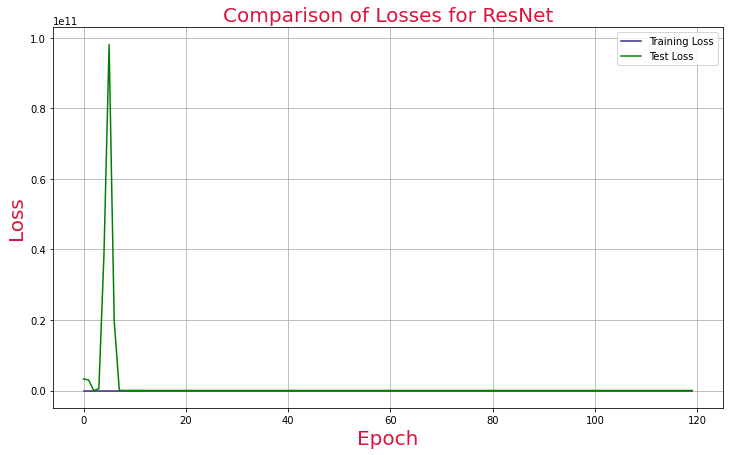

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Continue to Next Model? (Y/N)Y
                               Executing EfficientNet Model(196x196,180 Rotation)
Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 196, 196, 3)       84        
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                          

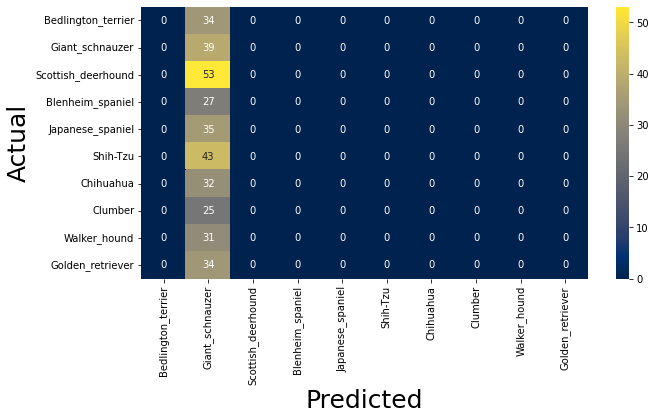

-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--
                    Performance Graph for EfficientNet Model(96x96,180 Rotation)
-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--


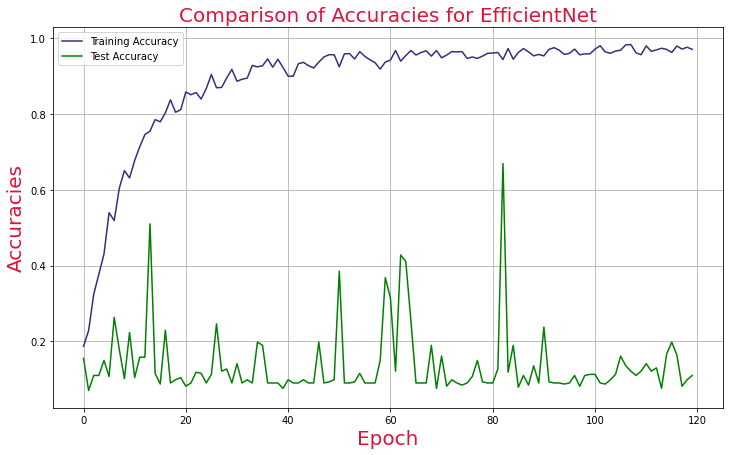

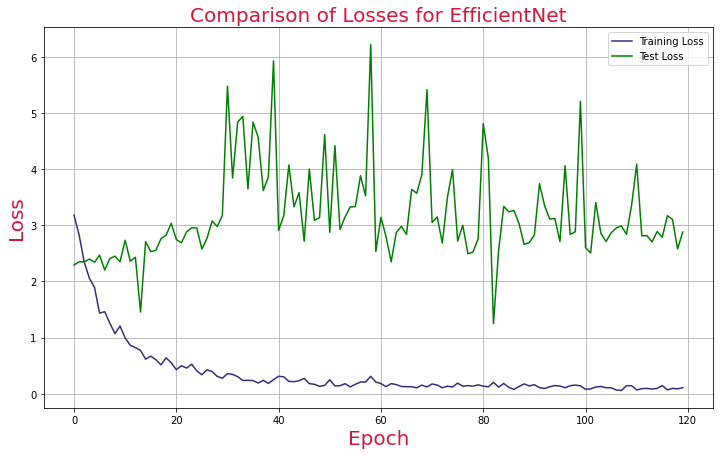

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Continue to Next Model? (Y/N)Y
                               Executing VGG Model(196x196,180 Rotation)
Model: "VGG"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 196, 196, 3)       84        
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048 

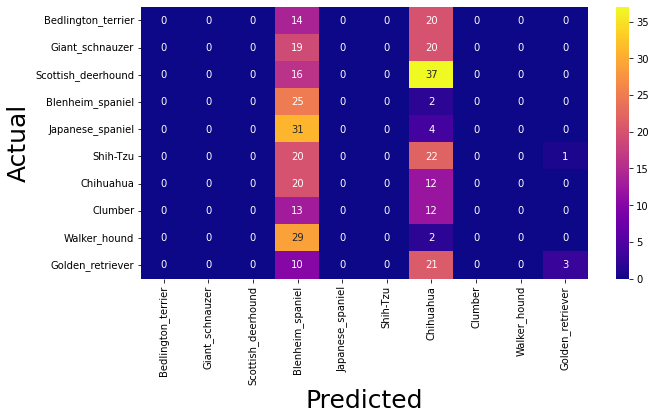

-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--
                    Performance Graph for VGG Model(96x96,180 Rotation)
-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--


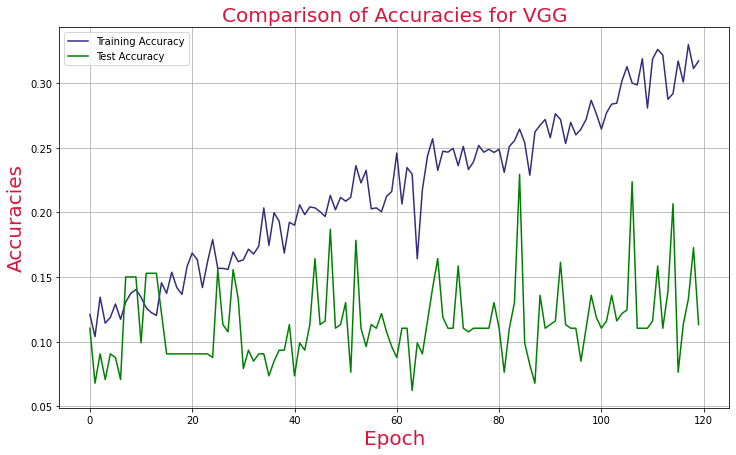

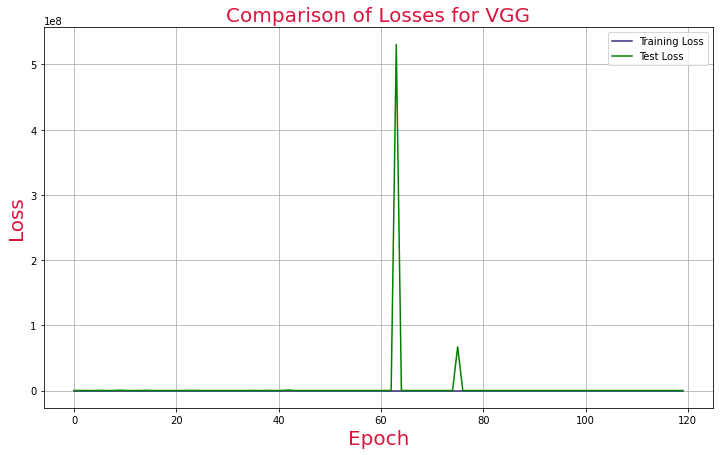

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Continue to Next Model? (Y/N)Y


In [ ]:
accdm2,prcdm2,rcldm2,f1dm2,accdm3tr,lossdm2tr=[],[],[],[],[],[]
epch=120
confclrs=["Accent","autumn","cividis","plasma"]
exemodels1=[]

def Func_DeepModels(modl):
    deep_model = modl

    input = Input(shape=(196,196, 3))
    lyrdm = Conv2D(3, (3, 3), padding='same')(input)
    lyrdm = deep_model(lyrdm)
    lyrdm = GlobalAveragePooling2D()(lyrdm)
    lyrdm = BatchNormalization()(lyrdm)
    lyrdm = Dropout(0.5)(lyrdm)
    lyrdm = Dense(256, activation='relu')(lyrdm)
    lyrdm = BatchNormalization()(lyrdm)
    lyrdm = Dropout(0.5)(lyrdm)
    output = Dense(10,activation = 'softmax', name='root')(lyrdm)
    dpm_model = Model(input,output, name="{}".format(dmnames[i]))
    dpm_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    dpm_model.summary()
    return dpm_model

for i in range(len(deepmods)):
    print("=================================================================================================")
    print("                               Executing {} Model(196x196,180 Rotation)".format(dmnames[i]))
    print("=================================================================================================")
    dpm_model = Func_DeepModels(deepmods[i])
    dpm_dct = dpm_model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                   steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                   epochs=epch,
                   verbose=2,
                   validation_data=(X_val, Y_val))
    exemodels1.append(dpm_model)
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    print("                    Test Performance for {} Model(96x96,180 Rotation)".format(dmnames[i]))
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    final_lossdpm, final_acrdpm = dpm_model.evaluate(X_val, Y_val)
    print('Final Loss: {}, Final Accuracy: {}%'.format(final_lossdpm, round(final_acrdpm,3)*100))
    accdm3tr.append(round(final_acrdpm,3)*100)
    lossdm2tr.append(round(final_lossdpm,3))
    
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    print("                    Confusion Matrix for {} Model(96x96,180 Rotation)".format(dmnames[i]))
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    Y_pred = dpm_model.predict(X_val)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.argmax(Y_val, axis=1)

    cm = confusion_matrix(Y_true, Y_pred)
    plt.figure(figsize=(10,5))
    ax = sns.heatmap(cm, fmt="d",annot=True,cmap=confclrs[i], xticklabels=ldis_typ, yticklabels=ldis_typ)
    ax.set_ylabel('Actual', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()
    accdm2.append(round(accuracy_score(Y_true,Y_pred),3)*100)
    prcdm2.append(round(precision_score(Y_true,Y_pred,average="weighted"),3)*100)
    rcldm2.append(round(recall_score(Y_true,Y_pred,average="weighted"),3)*100)
    f1dm2.append(round(f1_score(Y_true,Y_pred,average="weighted"),3)*100)
    dpm19df=pd.DataFrame({
        "Epoch":[i+1 for i in range(epch)],
        "Training Loss":dpm_dct.history['loss'],
        "Test Loss":dpm_dct.history['val_loss'],
        "Training Accuracy":dpm_dct.history['accuracy'],
        "Test Accuracy":dpm_dct.history['val_accuracy']
    })
    dpm19df.to_csv("coin_{}.csv".format(dmnames[i]))
    tlcol="#DC143C"
    v1,v2=1,3
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    print("                    Performance Graph for {} Model(96x96,180 Rotation)".format(dmnames[i]))
    print("-.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.--.-.-.--")
    dpm19df.iloc[:,v2:].plot(kind="line",figsize=(12,7),color=["#342D7E","#008000"])
    plt.title("Comparison of Accuracies for {}".format(dmnames[i]),fontsize=20,color=tlcol)
    plt.xlabel("Epoch",fontsize=20,color=tlcol)
    plt.ylabel("Accuracies",fontsize=20,color=tlcol)
    plt.grid()
    plt.show()

    dpm19df.iloc[:,v1:v2].plot(kind="line",figsize=(12,7),color=["#342D7E","#008000"])
    plt.title("Comparison of Losses for {}".format(dmnames[i]),fontsize=20,color=tlcol)
    plt.xlabel("Epoch",fontsize=20,color=tlcol)
    plt.ylabel("Loss",fontsize=20,color=tlcol)
    plt.grid()
    plt.show()
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    ch=input("Continue to Next Model? (Y/N)")
    if ch=="Y" or ch=="y":
      continue
    else:
      break


In [ ]:
accdf1=pd.DataFrame({"Model":dmnames,"Accuracy":accdm2,"Precision":prcdm2,"Recall":rcldm2,"F1":f1dm2,"Training Accuracy":accdm3tr,"Training Loss":lossdm2tr})
accdf1=accdf1.sort_values(by="Accuracy",ascending=False)

for i in accdf1.columns.tolist()[1:]:
    accout1=accdf1.sort_values(by=i,ascending=False)
    fig = px.bar(accout1, y=i, x="Model",color="Model",text=i,title="Comparison of {}".format(i),width=700)
    fig.update_layout(
        font=dict(
            family="Times New Roman, Bold",
            size=20,
            color="black"
        )
    )
    fig.show()